In [2]:
import os
import warnings

warnings.filterwarnings("ignore")

# Data Science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine Learning libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

In [3]:
# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [53]:
# Image processing libraries
import cv2
import gc
from PIL import Image
from glob import glob

# Object persistence libraries
import joblib

In [5]:
# Local modules
from utils import make_confusion_matrix

# Lung Cancer Detection

# Background
Lung cancer is one of the leading causes of death among Americans above the age of 35. Currently, doctors are unable to diagnose patients who develop lung cancer with accuracy, and even when patients are diagnosed with lung cancer, there are many times when the carcinoma is detected all too late. 

State-of-the-art computer vision tools have the ability to classify an assortment of objects in the real world and identify them. With the Lung and Colon Cancer Histopathological Image dataset on Kaggle, the aim of this project is to train several models (2 classical supervised learning algorithms + 2 deep CNNs) in order to predict whether a CT scan of the lungs of patients show any indicators of the development of Lung Adenocarcinomas or Lung Squamous Cell Carcinomas. 

# Dataset
## Lung and Colon Cancer Histopathological Images
- 25,000 images of 5 classes including lung and colon cancer and healthy samples
- Images of size 768 x 768 pixels in jpeg format
- HIPAA compliant
### Lung Image Dataset
- 750 original images of lung tissue
  - 250 benign lung tissue
  - 250 lung adenocarcinomas
  - 250 lung squamous cell carcinomas
  - Augmented to 25,0000 images

Original Article

Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019

## Data Preparation

In [6]:
lung_images = "data/lung_image_sets"
classes = os.listdir(lung_images)
classes

['lung_aca', 'lung_n', 'lung_scc']

Here, lung_n equates to CT scans of patients with normal lungs, lung_aca equates to CT scans of patients with lung adenocarcinomas, and lung_scc equates to CT scans of patients with lung squamous cell carcinomas.

In [7]:
class_map = {
    "lung_n": "Normal Lungs",
    "lung_aca": "Lung Adenocarcinomas",
    "lung_scc": "Lung Squamous Cell Carcinomas",
}

### Class Distribution

In [8]:
class_counts = {}
for c, condition in class_map.items():
    count = len(os.listdir(f"{lung_images}/{c}"))
    class_counts[condition] = count

class_counts

{'Normal Lungs': 5000,
 'Lung Adenocarcinomas': 5000,
 'Lung Squamous Cell Carcinomas': 5000}

Text(0, 0.5, '# Images')

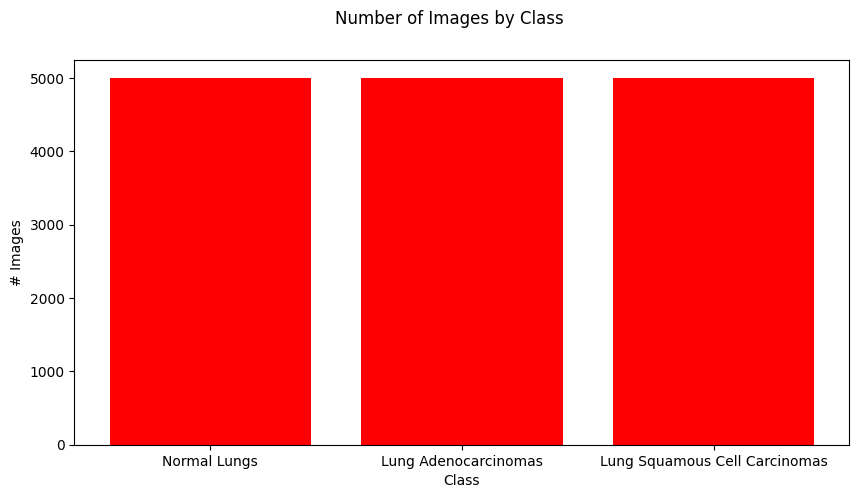

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Number of Images by Class")
ax.bar(class_counts.keys(), class_counts.values(), color="r")
ax.set_xlabel("Class")
ax.set_ylabel("# Images")

From the barplot above, we see that our dataset is well-balanced in terms of the number of samples we have in each class which can be used to train predictive models. Each class (normal lungs, lung adenocarcinomas, lung squamous cell carcinomas) has 5,000 image samples.

### Image Samples

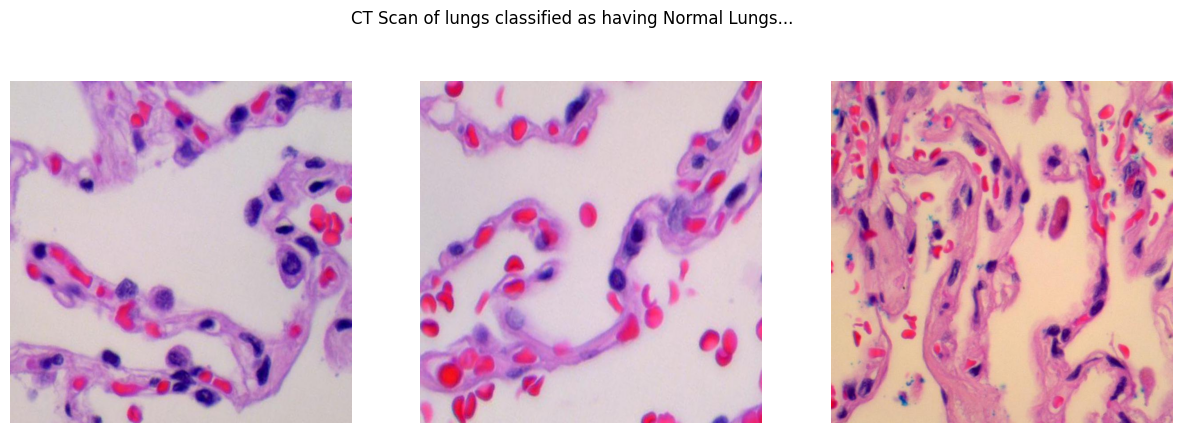

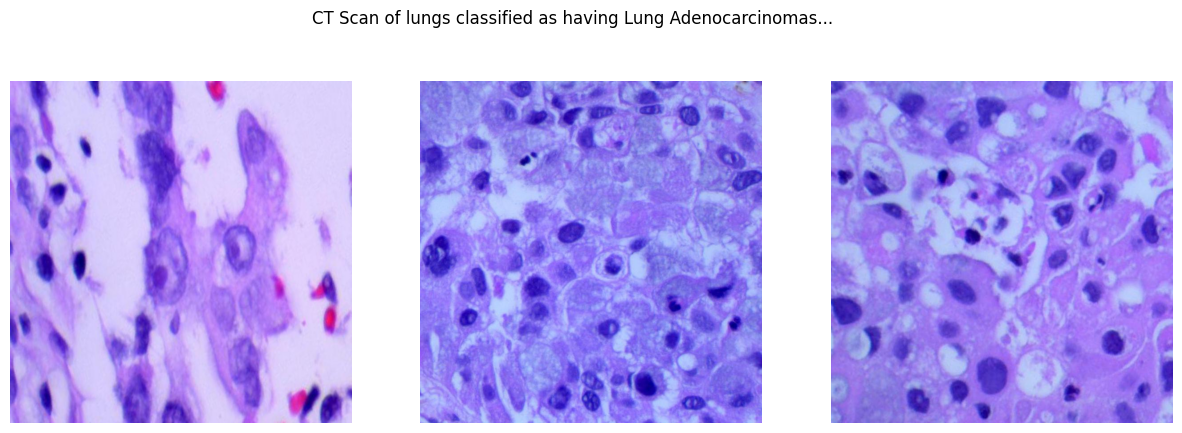

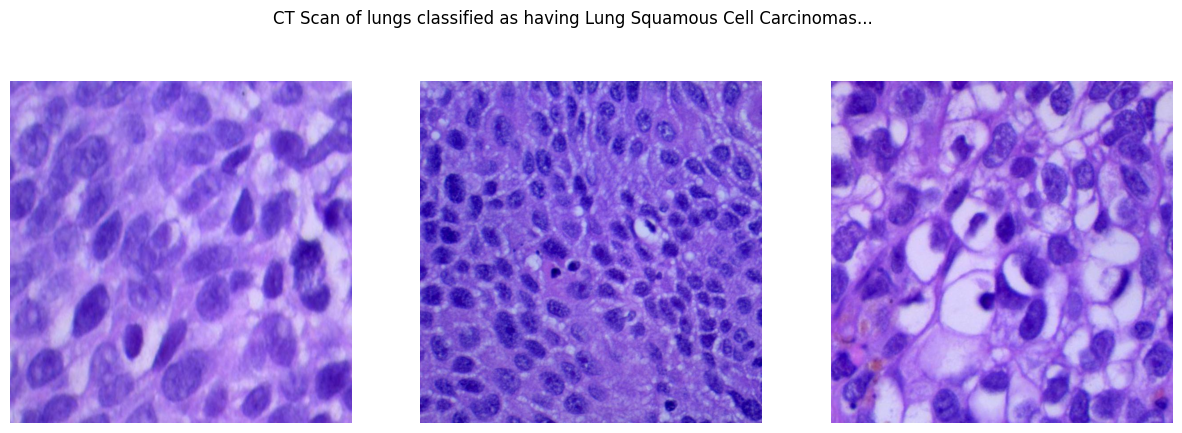

In [10]:
for c, condition in class_map.items():
    images = os.listdir(f"{lung_images}/{c}")

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"CT Scan of lungs classified as having {condition}...")

    for i in range(3):
        j = np.random.randint(0, len(images))
        img = np.array(Image.open(f"{lung_images}/{c}/{images[j]}"))
        ax[i].imshow(img)
        ax[i].axis("off")
    plt.show()

Above, we have plotted 3 image samples from each class just to get a view of the data for which our models will be working with. The most obvious difference between images samples in between the classes is that cell carcinomas (cells with lung adenocarcinomas and cells with lung squamous cell carcinomas) are stained purple while normal lung cells without carcinomas are stained pink. From rudimentary research, cell carcinomas can be properly detected and stained with a variety of methods including immunohistochemistry, H&E staining, dyes binding to cancer cell nuclei, etc.. 

This may prove to be a crucial feature in predictive analysis; however, cell staining seen in CT scans may not be enough to train a model which can accurately predict whether a CT scan of lung cells contains lung cell carcinomas or not. Let's continue with our EDA and examine what results we get from future predictive analysis.

### Image Dimensions

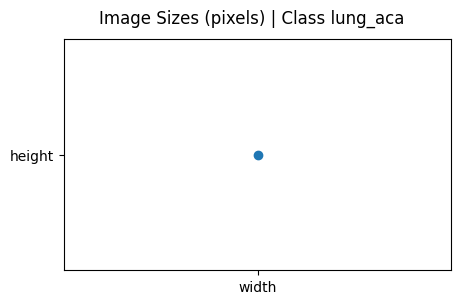

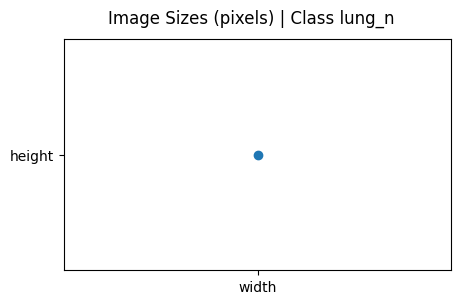

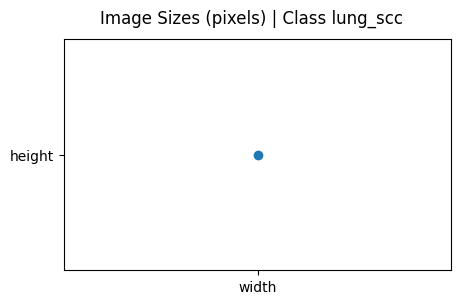

In [11]:
for i, c in enumerate(classes):
    images = glob(f"{lung_images}/{c}/*jpeg")

    fig, ax = plt.subplots(figsize=(5, 3))
    fig.suptitle(f"Image Sizes (pixels) | Class {c}")

    height, width = [], []
    for image in images:
        img = cv2.imread(image)
        h, w, c = img.shape
        height.append(h)
        width.append(w)

    ax.scatter(x="width", y="height")

Here, we see that all images in all classes have image dimensions of 768 pixels (height) x 768 pixels (width). Consistency in image sizes is pertinent when training CNNs for image processing. Our current dataset achieves that; however, let's downsize the images to reduce computation / training time for our image processing models as training a model on 768 x 768 x 3 images can be quite computationally expensive at scale.

### Image Processing / Resizing

In [12]:
IMAGE_SIZE = 128
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [13]:
X_ml = []
y_ml = []
X_dl = []

for i, c in enumerate(class_map.keys()):
    images = glob(f"{lung_images}/{c}/*jpeg")

    for image in images:
        img = cv2.imread(image)
        img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

        X_ml.append(img_resized.flatten())
        y_ml.append(i)
        X_dl.append(img_resized)

In [14]:
X_ml = np.array(X_ml)
y_ml = np.array(y_ml)
X_dl = np.array(X_dl)
y_dl = pd.get_dummies(y_ml).values

In [15]:
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=SPLIT, random_state=50
)
X_train_ml.shape, X_test_ml.shape, y_train_ml.shape, y_test_ml.shape

((12000, 49152), (3000, 49152), (12000,), (3000,))

In [16]:
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y_dl, test_size=SPLIT, random_state=50
)
X_train_dl.shape, X_test_dl.shape, y_train_dl.shape, y_test_dl.shape

((12000, 128, 128, 3), (3000, 128, 128, 3), (12000, 3), (3000, 3))

Now that we've finised our exploratory data analysis (EDA) and data preparation, we can move onto predictive analysis.

## Classical Machine Learning

In [17]:
def print_classification_metrics(y_true, y_pred, model_type):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)

    print(f"Test accuracy of {model_type} model: {accuracy:.2f}")
    print(f"Test precision of {model_type} model: {precision:.2f}")
    print(f"Test recall of {model_type} model: {recall:.2f}")
    print(f"Test f1 score of {model_type} model: {f1:.2f}")

### K-Nearest Neighbors

In [18]:
# K-Nearest Neighbors with N = 5
knn5 = KNeighborsClassifier()
knn5.fit(X_train_ml, y_train_ml)
knn5_pred = knn5.predict(X_test_ml)

In [19]:
knn5_pred

array([2, 0, 2, ..., 2, 0, 2])

In [20]:
cf_knn5 = confusion_matrix(y_test_ml, knn5_pred)
cf_knn5

array([[561, 349, 117],
       [  0,  70, 932],
       [  0,   1, 970]])

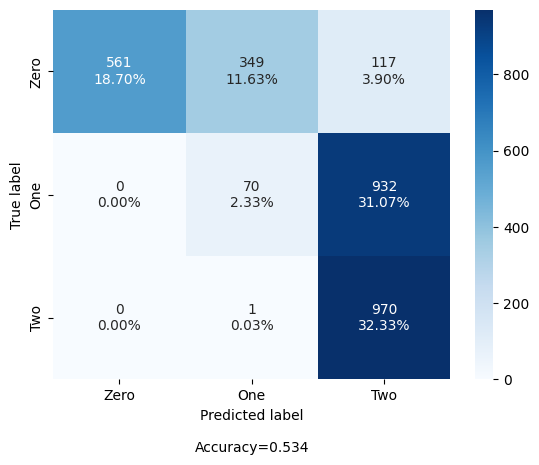

In [21]:
categories = ["Zero", "One", "Two"]
make_confusion_matrix(cf_knn5, categories=categories, cmap="Blues")

In [58]:
# K-Nearest Neighbors with N = 3
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train_ml, y_train_ml)
knn3_pred = knn3.predict(X_test_ml)
knn3_pred

array([2, 0, 2, ..., 2, 0, 2])

In [59]:
cf_knn3 = confusion_matrix(y_test_ml, knn3_pred)
cf_knn3

array([[624, 305,  98],
       [  0, 182, 820],
       [  0,   1, 970]])

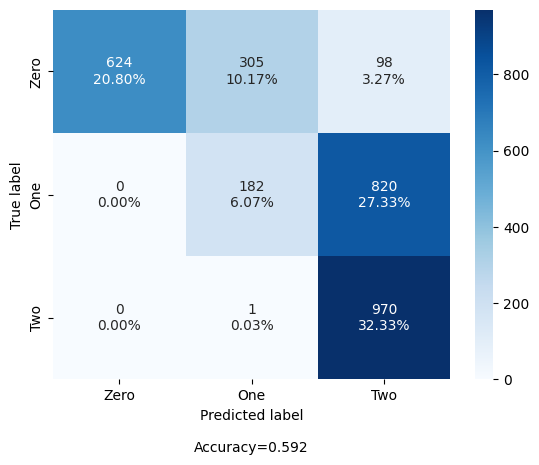

In [60]:
make_confusion_matrix(cf_knn3, categories=categories, cmap="Blues")

In [61]:
# K-Nearest Neighbors with N = 4
knn4 = KNeighborsClassifier(n_neighbors=4)
knn4.fit(X_train_ml, y_train_ml)
knn4_pred = knn4.predict(X_test_ml)
knn4_pred

array([2, 0, 2, ..., 2, 0, 2])

In [62]:
cf_knn4 = confusion_matrix(y_test_ml, knn4_pred)
cf_knn4

array([[674, 255,  98],
       [  0, 193, 809],
       [  0,   4, 967]])

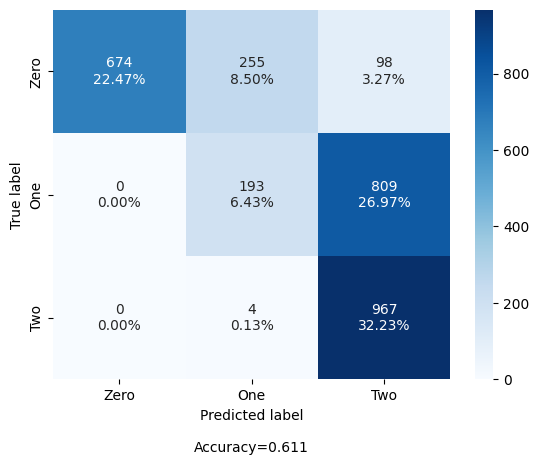

In [63]:
make_confusion_matrix(cf_knn4, categories=categories, cmap="Blues")

In [ ]:
# Save the Polynomial Kernel SVC model
joblib.dump(knn4, "models/knn4.pkl")

### Support Vector Machine

#### Linear Kernel SVC

In [48]:
linear_kernel_svc = Pipeline([
    ('Scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='linear', C=5))
])

In [ ]:
# Load Polynomial Kernel SVC model from pkl file
# polynomial_kernel_svc = joblib.load("models/linear_kernel_svc.pkl")
# polynomial_kernel_svc

In [49]:
linear_kernel_svc.fit(X_train_ml, y_train_ml)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, kernel='linear'))])

In [50]:
linear_kernel_svc_pred = linear_kernel_svc.predict(X_test_ml)
linear_kernel_svc_pred

array([1, 0, 0, ..., 2, 0, 1])

In [51]:
cf_linear_kernel_svc = confusion_matrix(y_test_ml, linear_kernel_svc_pred)
cf_linear_kernel_svc

array([[1001,   23,    3],
       [  28,  619,  355],
       [   2,  241,  728]])

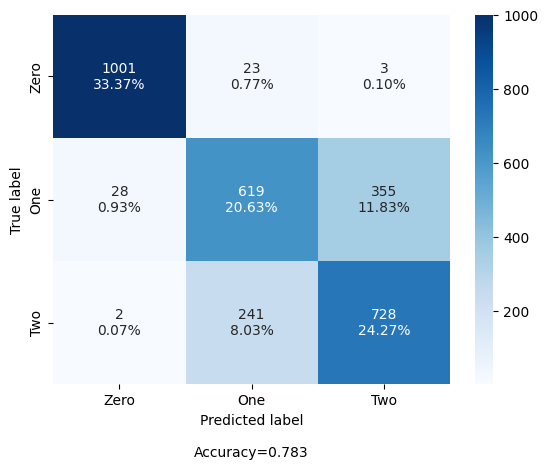

In [52]:
make_confusion_matrix(cf_linear_kernel_svc, categories=categories, cmap="Blues")

In [57]:
# Save the Linear Kernel SVC model
joblib.dump(linear_kernel_svc, "models/linear_kernel_svc.pkl")

['models/linear_kernel_svc.pkl']

#### Polynomial Kernel SVC

In [38]:
polynomial_kernel_svc = Pipeline([
    ('Scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])

In [ ]:
# Load Polynomial Kernel SVC model from pkl file
# polynomial_kernel_svc = joblib.load("models/polynomial_kernel_svc.pkl")
# polynomial_kernel_svc

In [39]:
polynomial_kernel_svc.fit(X_train_ml, y_train_ml)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [40]:
polynomial_kernel_svc_pred = polynomial_kernel_svc.predict(X_test_ml)
polynomial_kernel_svc_pred

array([1, 0, 0, ..., 2, 0, 2])

In [41]:
cf_polynomial_kernel_svc = confusion_matrix(y_test_ml, polynomial_kernel_svc_pred)
cf_polynomial_kernel_svc

array([[1009,   16,    2],
       [   4,  787,  211],
       [   0,   47,  924]])

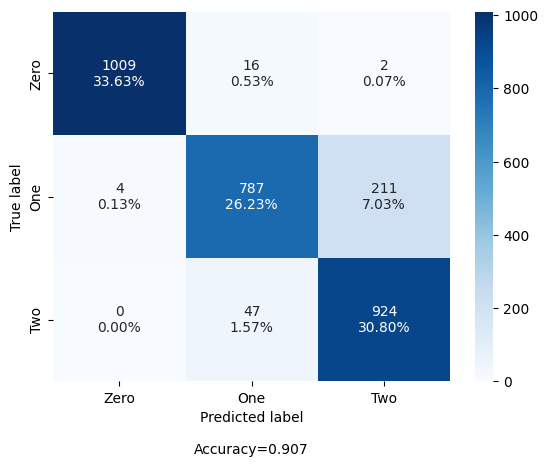

In [54]:
make_confusion_matrix(cf_polynomial_kernel_svc, categories=categories, cmap="Blues")

In [55]:
# Save the Polynomial Kernel SVC model
joblib.dump(polynomial_kernel_svc, "models/polynomial_kernel_svc.pkl")

['models/polynomial_kernel_svc.pkl']

#### Guassian RBF Kernel SVC

In [43]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])

In [44]:
rbf_kernel_svm_clf.fit(X_train_ml, y_train_ml)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

In [45]:
rbf_kernel_svc_pred = rbf_kernel_svm_clf.predict(X_test_ml)
rbf_kernel_svc_pred

array([2, 2, 2, ..., 2, 2, 2])

In [46]:
cf_rbf_kernel_svc = confusion_matrix(y_test_ml, rbf_kernel_svc_pred)
cf_rbf_kernel_svc

array([[   0,    0, 1027],
       [   0,    0, 1002],
       [   0,    0,  971]])

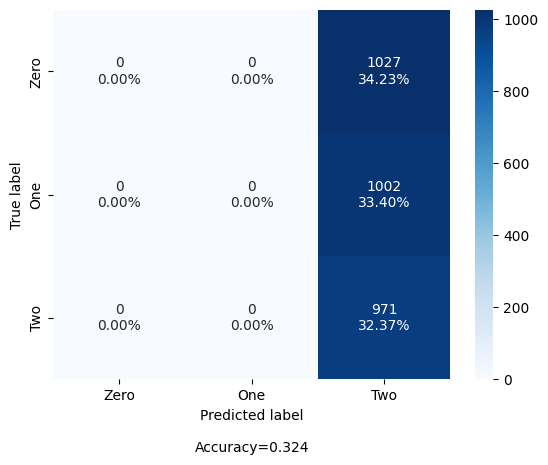

In [47]:
make_confusion_matrix(cf_rbf_kernel_svc, categories=categories, cmap="Blues")

#### Black and Whiten Images

## Deep Learning

### AlexNet Architecture

### VGGNet

### Resnet

### Dense Net

### Efficient Net